# Parent Hamiltonian with MPS

For **Parent Hamiltonian** computations (**PH**) one mandatory step is computing the final state of the input ansatz. This approach has several important issues when the number of qubits increases:

* The vector state simulation is very computing demanding for a high number of qubits: for more than 30 qubits, high-performance resources are needed and for more than 40 qubits this computation is unaffordable for most power classical computers.
* Even in the case of having an efficient way of computing the state a second problem arises: the memory needed for storing a complete quantum state grows exponentially with the number of qubits so the **PH** computation can not be performed when the number of qubits increases because we can't hold the state in memory.

To avoid these issues instead of state vector simulations, **Tensor Networks** (**TN**) techniques as **Matrix Product State** (**MPS**) can be used. In addition to their power computation, once the final **MPS** representation of the state is obtained, the state computation is not mandatory because the main calculations needed for the **PH** (the computing of the reduced density matrix) can be performed in a very efficient way using **TN** techniques over the **MPS**.

Several modules were included in our library, for using this **MPS** formalism to obtain the desired **PH** for the used ansatz, for different numbers of qubits and different depths. The modules, grouped under the package **PH.mps**, are:

* **PH.mps.gates_mps**: this module contains a numpy implementation of the different gates needed for programming the mandatory ansatz of the **BTC**.
* **PH.mps.mps**: this module contains several functions needed for doing the computations of the **MPS** formalism.
* **PH.mps.ansatz_mps**: this module contains the functions for building the **MPS** representation of the mandatory ansatz of the **BTC**.
* **PH.mps.parent_hamiltonian_mps**: this module contains the mandatory functions to compute the **PH** using **MPS**. This is a very similar package to the **parent_hamiltonian** one but the reduced density matrix calculations are done using **MPS** techniques.

The **PH.mps.parent_hamiltonian_mps** has all the functions for building the **PH** for the **BTC** ansatz for several qubits and depths in a very easy and straightforward way. In this Notebook, the **PH.mps.parent_hamiltonian_mps** will be explained. The **MPS** computations implemented in the different modules will be explained in the following notebooks.


In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.INFO
    #level=logging.DEBUG
)
logger = logging.getLogger('__name__')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import sys
sys.path.append("../../")

## 1. parent_hamiltonian_mps module

The main function of this package is the **run_parent_hamiltonian** one. This function computes the Pauli decomposition of the **PH** for the ansatz **BTC** for a given number of qubits and depth. The input of the function is the **configuration** python **kwargs**. The main keyword arguments that should be provided are:

* **nqubits**: it holds the number of qubits desired for **BTC** ansatz.
* **depth**: it holds the depth desired for the **BTC** ansatz.
* **truncate**: For truncating the SVD in the **MPS** computation.
* **save**: for saving the decomposition.
* **folder**: Folder where the results will be stored.

The Workflow of the function is the following:

1. Compute the **MPS** of the **BTC** ansatz for the desired **nqubits** and **depth** (this uses functions from **ansatz_mps** package).
2. The **PH_MPS** class (similar to the **PH** class, see *02_Using_PH_Class.ipynb*) is used for computing the **PH** and its corresponding Pauli decomposition.
3. The **PH_MPS** class takes as input the resulting **MPS** respresentation of the **BTC** ansatz and uses different **TN** techniques (implemented in the **mps** package) for computing the mandatory reduced density matrices. 
4. When the Pauli decomposition of the **PH** is obtained and if the **save** option was provided the results are stored in the following files:
    * {base_fn}_parameters.csv: file for storing the angles for the **BTC** ansatz.
    * {base_fn}_pauli.csv: file for sotring the Pauli decomposition of the **PH** for the  **BTC** ansatz.
    * {base_fn}_mps_ph_time.csv: file for storing the time that the code needed for the **PH** computations.
    * The base_fn will have the following pattern: **ansatz\_simple01\_nqubits\_{nqubits}\_depth_{depth}_mps**
    
The {base_fn}_parameters.csv and the {base_fn}\_pauli.csv have compatible formats for using it, straightforwardly, with the **vqe_step** module (see notebook *03_ParentHamiltonian_execution.ipynb*)

In [ ]:
from PH.mps.parent_hamiltonian_mps import run_parent_hamiltonian as mps_run_ph

In [ ]:
nqubits = 10
depth = 4
config = {
    "nqubits": nqubits, 
    "depth": depth, 
    "truncate": True,
    "save": False,
    "t_inv": True,
    "t_v" : None,
    "folder": ""
}

In [ ]:
pauli_mps, angles_mps = mps_run_ph(**config)

In [ ]:
pauli_mps.head()

In [ ]:
len(pauli_mps)

In [ ]:
angles_mps

### State Vector results

We are going to compare the **MPS** **PH** computations versus the **State Vector** ones.

In [ ]:
# PH usign State Vector libraries
from PH.parent_hamiltonian.parent_hamiltonian import PH
from PH.ansatzes.ansatzes import run_ansatz
# myQLM qpus
sys.path.append("../../../")
from qpu.select_qpu import select_qpu
# List with the strings that should be provided for an ideal QPU
ideal_qpus = ["c", "python", "linalg", "mps", "qlmass_linalg", "qlmass_mps"]
qpu_config = {
    "qpu_type": ideal_qpus[0], 
}
qpu = select_qpu(qpu_config)

In [ ]:
# First Compute state using State Vector
config.update({
    "ansatz" : "simple01",
    "qpu" : qpu,
})
output = run_ansatz(**config)
state = output["state"]
angles_statev = output["parameters"]

In [ ]:
print("Testing angles. OK? : {}".format(
    (angles_statev == angles_mps).all().all()))

In [ ]:
# Compute PH computations for state
ph_object = PH(
    list(state["Amplitude"]), config["t_inv"], **config)
ph_object.local_ph()
pauli_statev = ph_object.pauli_pdf

In order to compare Pauli Coefficients from **MPS** and from **State Vector** simulation we need to discard the Pauli Coefficients that are zero. In this case we are going to set a cutt-off of $10^{-7}$. So Pauli coefficients with absolute value lower than the cutt-off will be considered as cero and deleted from the DataFrames

In [ ]:
len(pauli_statev)

In [ ]:
len(pauli_mps)

In [ ]:
pdf_final = pd.merge(
    pauli_statev, 
    pauli_mps,
    on = "PauliStrings",
    how="outer"
).fillna(0.0)

In [ ]:
# Testing if both coefs are equal
np.isclose(
    pdf_final["PauliCoefficients_x"].astype(float),
    pdf_final["PauliCoefficients_y"].astype(float),
).all()

### VQE step computation 

Now we can use the **vqe_step** module for computing the **VQE** step of the computed **PH**.

In [ ]:
from PH.ansatzes.ansatzes import ansatz_selector, angles_ansatz01
from PH.ph_step_exe.vqe_step import PH_EXE

In [ ]:
# myQLM circuit implementation of the ansatz
ansatz_conf = {"nqubits" :nqubits, "depth" : depth}
circuit = ansatz_selector("simple01", **ansatz_conf)
circuit, _ = angles_ansatz01(circuit, angles_mps)

In [ ]:
%qatdisplay circuit --svg

In [ ]:
# myQLM qpus
from qat.qpus import CLinalg
qpu_c = CLinalg()

In [ ]:
vqe_conf = {
    "qpu": qpu_c, 
    "truncation" : None,
    "t_inv" : True,
    "save": False,
    "filename" : ""
}

In [ ]:
# First we instantiate the object
exe_ph = PH_EXE(circuit, pauli_mps, nqubits, **vqe_conf)

In [ ]:
# Executes the run method
exe_ph.run()

In [ ]:
# Here the Ground State Energy
exe_ph.pdf

## 2 MPS Times

In order to provide an overview of why use **MPS** in the following graphs several time comparisons for computing **PH** for different **number of qubits** and **depths** using **myQLM StateVector** and **MPS** are shown:

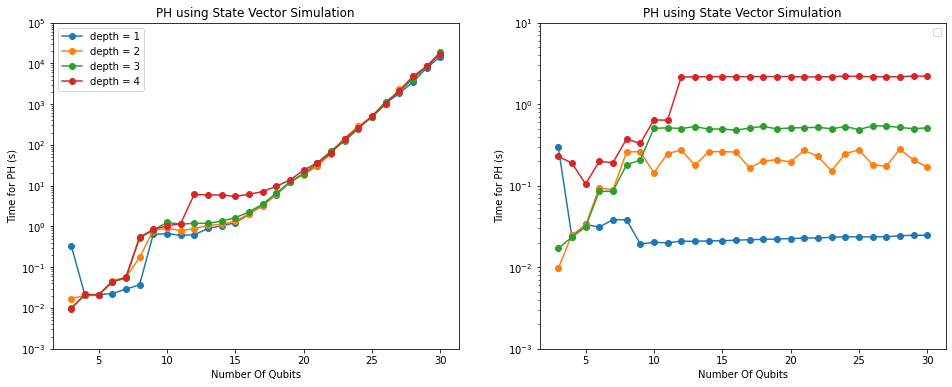

In the following graphs we compare **State Vector** and **MPS** times for computing **PH** for different **depths**

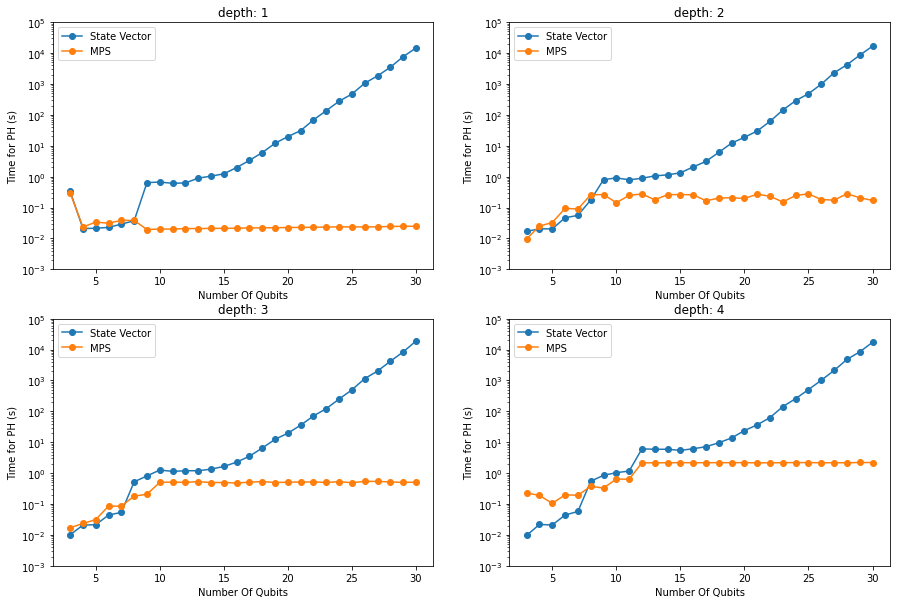

## 3. Command line execution

The **parent_hamiltonian_mps.py** module can be executed from the command line. Several arguments can be provided for configuring the complete execution. To get help type:

    parent_hamiltonian_mps.py -h
    
    
    usage: parent_hamiltonian_mps.py [-h] [-nqubits NQUBITS] [-depth DEPTH] [--truncate] [-t_v T_V] [--t_inv] [--save] [-folder FOLDER] [--print] [--exe]

    optional arguments:
      -h, --help        show this help message and exit
      -nqubits NQUBITS  Number of qbits for the ansatz.
      -depth DEPTH      Depth for ansatz.
      --truncate        Truncating the SVD. Float resolution will be used
      -t_v T_V          Truncation Value for SVD in the MPS computations
      --t_inv           Setting translational invariant of the ansatz
      --save            For storing results
      -folder FOLDER    Folder for Storing Results
      --print           For printing the AE algorihtm configuration.
      --exe             For executing program   
    
   
**Example**

For doing a parent Hamiltonian computation for a *simple01* ansatz of 24 *qubits* with *depth* 4 type and with a truncation for SVD of 0.001 type

    python  parent_hamiltonian_mps.py -nqubits 24 -depth 4 --truncate -t_v 0.001 --t_inv --save  --exe -folder SavesMPS
    
In this case following CSV files should be generated:

* SavesMPS/ansatz_simple01_nqubits_24_depth_4_qpu_mps_parameters.csv 
* SavesMPS/ansatz_simple01_nqubits_24_depth_4_qpu_mps_pauli.csv
* SavesMPS/ansatz_simple01_nqubits_24_depth_4_qpu_mps_ph_time.csv